<a href="https://colab.research.google.com/github/AsmaaYassinDev/Context-Aware-Fraud-Detection/blob/main/train_logistic_baseline_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please upload 'kaggle.json':


Saving kaggle.json to kaggle.json
Loading and Optimizing Data...


/tmp/ipython-input-2880309146.py:43: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max: df[col] = df[col].astype(np.float16)
/tmp/ipython-input-2880309146.py:43: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max: df[col] = df[col].astype(np.float16)
/tmp/ipython-input-2880309146.py:43: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max: df[col] = df[col].astype(np.float16)
/tmp/ipython-input-2880309146.py:43: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max: df[col] = df[col].astype(np.float16)
/tmp/ipython-input-2880309146.py:43: RuntimeWarning: overflow encountered in cast
  if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max: df[col] = df[col].astype(np.float16)
/tmp/ipython-input-288030

Filtering columns...

--- ROBUST UID GENERATION START ---


/tmp/ipython-input-2880309146.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['hour'] = (df['TransactionDT'] // 3600) % 24
/tmp/ipython-input-2880309146.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['UID'] = s_card + '_' + s_addr + '_' + s_email


Generating Behavioral Features (Expanding Windows)...


/tmp/ipython-input-2880309146.py:96: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['User_Trans_Count'] = df.groupby('UID').cumcount() + 1
/tmp/ipython-input-2880309146.py:97: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['User_Mean_Amt'] = df.groupby('UID')['TransactionAmt'].transform(lambda x: x.expanding().mean())
/tmp/ipython-input-2880309146.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

✅ Features Created.

--- TRAINING LOGISTIC REGRESSION BASELINE ---
Preparing Data (Imputing & Scaling)...
Fitting Logistic Regression (Class Weight='balanced')...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



--- EVALUATION RESULTS ---
Best Threshold: 0.7904
ROC-AUC:        0.8256
Precision:      0.2526
Recall:         0.3770
F1-Score:       0.3025

Generating Confusion Matrix...


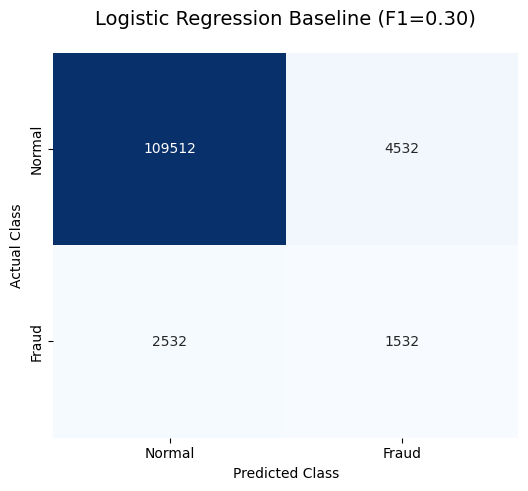

In [1]:
import os
import gc
import numpy as np
import pandas as pd
from google.colab import files
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_curve, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

# =========================================================
# 1. ROBUST DATA LOADING
# =========================================================
def force_download():
    if os.path.exists('train_transaction.csv'):
        print("✅ Data found.")
        return
    if not os.path.exists('/root/.kaggle/kaggle.json'):
        print("Please upload 'kaggle.json':")
        files.upload()
        os.system('mkdir -p ~/.kaggle')
        os.system('cp kaggle.json ~/.kaggle/')
        os.system('chmod 600 ~/.kaggle/kaggle.json')
    os.system('kaggle competitions download -c ieee-fraud-detection')
    os.system('unzip -o ieee-fraud-detection.zip')
    os.system('unzip -o train_transaction.csv.zip')
    os.system('unzip -o train_identity.csv.zip')

force_download()

def reduce_mem_usage(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min, c_max = df[col].min(), df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max: df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max: df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max: df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max: df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max: df[col] = df[col].astype(np.float32)
    return df

print("Loading and Optimizing Data...")
train_trans = reduce_mem_usage(pd.read_csv('train_transaction.csv'))
train_id = reduce_mem_usage(pd.read_csv('train_identity.csv'))
df = pd.merge(train_trans, train_id, on='TransactionID', how='left')
del train_trans, train_id
gc.collect()

# =========================================================
# 2. FEATURE ENGINEERING (IDENTICAL TO ORIGINAL)
# =========================================================
# 1. Sort by Time
df = df.sort_values('TransactionDT').reset_index(drop=True)

# A. Filtering
print("Filtering columns...")
df = df.drop(columns=df.columns[df.isnull().mean() > 0.95])
df = df.drop(columns=df.nunique()[df.nunique() == 1].index)

# B. Imputation
for col in df.select_dtypes(include=['object']).columns: df[col] = df[col].fillna('Unknown')
for col in df.select_dtypes(exclude=['object']).columns: df[col] = df[col].fillna(-1)

# C. Timezone Fix
if 'id_14' in df.columns: df['id_14'] = df['id_14'].astype(str)

# D. Encoding
for col in df.select_dtypes(include=['object']).columns:
    if col not in ['card1', 'addr1', 'P_emaildomain']:
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# E. User Profiling & Entity Resolution
print("\n--- ROBUST UID GENERATION START ---")
df['hour'] = (df['TransactionDT'] // 3600) % 24

# Construct UID Robustly
s_card = df['card1'].astype(str).replace({'-1': 'NoCard', 'nan': 'NoCard'})
s_addr = df['addr1'].astype(str).replace({'-1': 'NoAddr', 'nan': 'NoAddr', '0': 'NoAddr'})
s_email = df['P_emaildomain'].astype(str).replace({'Unknown': 'NoEmail', 'nan': 'NoEmail'})

df['UID'] = s_card + '_' + s_addr + '_' + s_email
df['UID'] = LabelEncoder().fit_transform(df['UID'])

# Encode remaining objects
for col in ['card1', 'addr1', 'P_emaildomain']:
    if df[col].dtype == 'object':
         df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# F. Behavioral Profiling (Expanding Windows)
print("Generating Behavioral Features (Expanding Windows)...")
df['User_Trans_Count'] = df.groupby('UID').cumcount() + 1
df['User_Mean_Amt'] = df.groupby('UID')['TransactionAmt'].transform(lambda x: x.expanding().mean())
df['Amt_Deviation'] = df['TransactionAmt'] / (df['User_Mean_Amt'] + 1e-5)
df['User_Hour_Mean'] = df.groupby(['UID', 'hour'])['TransactionAmt'].transform(lambda x: x.expanding().mean())
df['Time_Behavior_Deviation'] = df['TransactionAmt'] / (df['User_Hour_Mean'] + 1e-5)
print("✅ Features Created.")

# =========================================================
# 3. SPLITTING (STRICT 80/20 TIME-SERIES)
# =========================================================
split_idx = int(len(df) * 0.8)
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

exclude = ['isFraud', 'TransactionID', 'TransactionDT', 'UID', 'User_Mean_Amt', 'User_Hour_Mean']
features = [c for c in df.columns if c not in exclude]

X_train, y_train = train_df[features], train_df['isFraud']
X_test, y_test = test_df[features], test_df['isFraud']

# =========================================================
# 4. LOGISTIC REGRESSION TRAINING
# =========================================================
print("\n--- TRAINING LOGISTIC REGRESSION BASELINE ---")
print("Preparing Data (Imputing & Scaling)...")

# Logistic Regression requires scaling and handling NaN/Infinity better than XGBoost
imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_imp)
X_test_sc = scaler.transform(X_test_imp)

print("Fitting Logistic Regression (Class Weight='balanced')...")
lr_model = LogisticRegression(
    class_weight='balanced',
    solver='saga',
    max_iter=50,  # Kept low for speed, increase for convergence if needed
    random_state=42,
    n_jobs=-1
)
lr_model.fit(X_train_sc, y_train)
y_probs_lr = lr_model.predict_proba(X_test_sc)[:, 1]

# =========================================================
# 5. EVALUATION & CONFUSION MATRIX
# =========================================================
print("\n--- EVALUATION RESULTS ---")

# Calculate Best Threshold based on F1 Score
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs_lr)
fscores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
best_idx = np.argmax(fscores)
best_thresh_lr = thresholds[best_idx]
y_pred_lr = (y_probs_lr >= best_thresh_lr).astype(int)

# Calculate Metrics
auc = roc_auc_score(y_test, y_probs_lr)
p = precision_score(y_test, y_pred_lr)
r = recall_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr)

print(f"Best Threshold: {best_thresh_lr:.4f}")
print(f"ROC-AUC:        {auc:.4f}")
print(f"Precision:      {p:.4f}")
print(f"Recall:         {r:.4f}")
print(f"F1-Score:       {f1:.4f}")

# Plot Confusion Matrix
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
    plt.title(title, fontsize=14, pad=20)
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()

print("\nGenerating Confusion Matrix...")
plot_cm(y_test, y_pred_lr, f'Logistic Regression Baseline (F1={f1:.2f})')


--- 📊 LOGISTIC REGRESSION FEATURE RANKINGS 📊 ---
Feature Name              | Rank  | Coeff (Abs)  | Direction
-----------------------------------------------------------------
User_Trans_Count          | #246  | 0.0181       | Positive
Amt_Deviation             | #45   | 0.0672       | Positive
Time_Behavior_Deviation   | #177  | 0.0279       | Positive
User_Mean_Amt             | ----  | 0.0000       | ❌ NOT USED
User_Hour_Mean            | ----  | 0.0000       | ❌ NOT USED
hour                      | #207  | 0.0240       | Negative

--- 🏆 COMPARISON WITH #1 FEATURE ---
Top Feature is: card6 (Coeff: 0.2709)


/tmp/ipython-input-1170974481.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=plot_df, palette=colors)


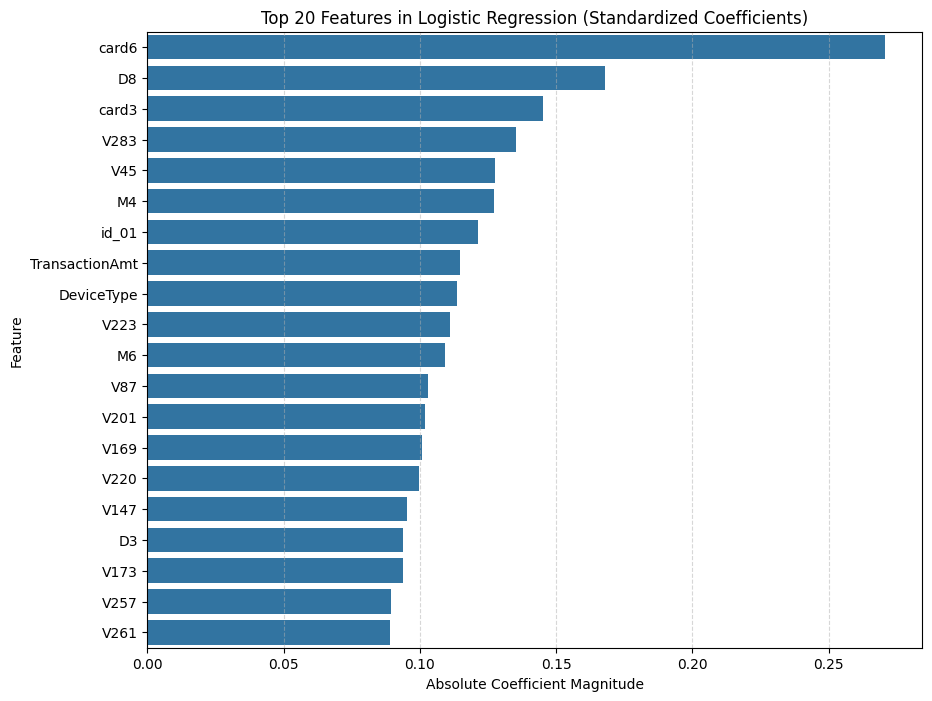

✅ Graph saved as Logistic_Regression_Top20_Features.png


In [2]:
# =========================================================
# 6. THESIS VALIDATION: LOGISTIC REGRESSION FEATURE RANKING
# Metric: Absolute Coefficient Magnitude (Standardized)
# =========================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- 📊 LOGISTIC REGRESSION FEATURE RANKINGS 📊 ---")

# 1. Extract Coefficients
# Logistic Regression coefficients indicate the direction and strength of the relationship
# take the absolute value to determine "Importance" regardless of direction (+ or -)
coeffs = np.abs(lr_model.coef_[0])

# Create DataFrame
imp_df = pd.DataFrame({
    'Feature': features,  # From your existing features list
    'Importance': coeffs,
    'Direction': ['Positive' if c > 0 else 'Negative' for c in lr_model.coef_[0]]
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Add Rank
imp_df['Rank'] = imp_df.index + 1

# 2. Check Your Engineered Features
my_features = [
    'User_Trans_Count',         # Velocity
    'Amt_Deviation',            # Contextual Spending
    'Time_Behavior_Deviation',  # Contextual Timing
    'User_Mean_Amt',            # User Habit
    'User_Hour_Mean',           # User Context
    'hour'                      # Temporal
]

print(f"{'Feature Name':<25} | {'Rank':<5} | {'Coeff (Abs)':<12} | {'Direction'}")
print("-" * 65)

found_features = []
for feat in my_features:
    if feat in imp_df['Feature'].values:
        row = imp_df[imp_df['Feature'] == feat].iloc[0]
        print(f"{feat:<25} | #{int(row['Rank']):<4} | {row['Importance']:<12.4f} | {row['Direction']}")
        found_features.append(feat)
    else:
        print(f"{feat:<25} | ----  | 0.0000       | ❌ NOT USED")

# 3. Compare with Top 1 Feature
top_feat = imp_df.iloc[0]
print("\n--- 🏆 COMPARISON WITH #1 FEATURE ---")
print(f"Top Feature is: {top_feat['Feature']} (Coeff: {top_feat['Importance']:.4f})")

# 4. Visualization (Top 20 Coefficients)
if len(found_features) > 0:
    plt.figure(figsize=(10, 8))
    plot_df = imp_df.head(20)

    # Color code: Red for your features, Blue for others
    colors = ['red' if x in my_features else '#1f77b4' for x in plot_df['Feature']]

    sns.barplot(x='Importance', y='Feature', data=plot_df, palette=colors)
    plt.title('Top 20 Features in Logistic Regression (Standardized Coefficients)')
    plt.xlabel('Absolute Coefficient Magnitude')
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.savefig('Logistic_Regression_Top20_Features.png', bbox_inches='tight', dpi=300)
    plt.show()
    print("✅ Graph saved as Logistic_Regression_Top20_Features.png")